# User Churn Prediction

Machine learning and big data processing will affect a wide range of industries, including the financial services industry. In order to increase my financial analysis skills, I learned machine learning in extracurricular time. User analysis and Churn Prediction is one of the projects I did.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
<li>[Part 5: Use Probabilities as Prediction Results](#Part-5:-Use-Probabilities-as-Prediction-Results)
</ul>

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
churn_df = pd.read_csv('../data/churn.all')

In [5]:
churn_df.ix[0]

state                                   KS
account_length                         128
area_code                              415
phone_number                      382-4657
intl_plan                               no
voice_mail_plan                        yes
number_vmail_messages                   25
total_day_minutes                    265.1
total_day_calls                        110
total_day_charge                     45.07
total_eve_minutes                    197.4
total_eve_calls                         99
total_eve_charge                     16.78
total_night_minutes                  244.7
total_night_calls                       91
total_night_charge                   11.01
total_intl_minutes                      10
total_intl_calls                         3
total_intl_charge                      2.7
number_customer_service_calls            1
churned                             False.
Name: 0, dtype: object

In [6]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


### Part 1.2: Data cleaning

Remove Extra Whitespace

Shike: view element and check if we need to clean it.

In [8]:
churn_df['voice_mail_plan'][0]

' yes'

In [9]:
churn_df['intl_plan'][0]

' no'

In [11]:
churn_df['churned'][0]

' False.'

Shike: map function can help us use one method to clean our raw data

In [12]:
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].map(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].map(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].map(lambda x: x.strip())

In [13]:
churn_df['churned'][0]

'False.'

### Part 1.3:  Understand the features

Shike: seaborn displot shows a good histogram and density curve. We can control a lot of custom featur of our graph.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


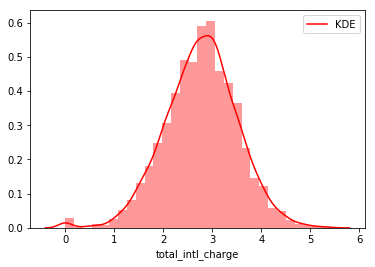

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(churn_df['total_intl_charge'], bins = 30, kde = True, color = 'r', kde_kws = {'label' : 'KDE'})

Shike: We can use heatmap visualize pearson correlation coefficient. Actually, graph below display a bad linear relationship between variables. Almost all of them are close to 0. But, *minutes and *charge have pretty high correlation coefficient.

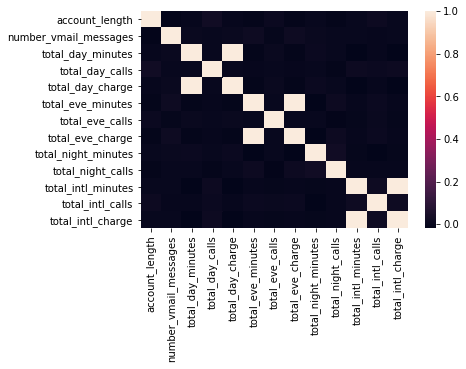

In [10]:
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

sb.heatmap(corr, )

Shike: Calculate a Pearson correlation coefficient and the p-value for testing
non-correlation. Thus, we can get a tuple, tuple[0] is R, tuple[1] is P-value. If P-value > 0.05, we cannot reject H0, there is no significant linear relationship.

In [11]:
from scipy.stats import pearsonr
print (pearsonr(churn_df['total_day_minutes'], churn_df['number_vmail_messages']))

(0.005381375960654535, 0.7036274686418728)


# Part 2: Feature Preprocessing

In [12]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [13]:
test = churn_df.copy()

Shike: According to numpy where function, we can get one array consisting of our argument depending on condition.
       data frame drop method can help us remove column or rows. Actually, we can use axis = 0 or 1 to control our            manipulation.
       data frame's as_matrix method can help us get numpy-array
       

In [14]:
# Get ground truth data
y = np.where(churn_df['churned'] == 'True.',1,0)

# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'
# Converts data frame to its Numpy-array representation.
X = churn_feat_space.as_matrix().astype(np.float)

Shike:
Here, we can use two methods to encode qualitative variable.
Method-1: use LabelBinarizer class in sklearn
Method-2: use get_dummies in pandas


In [18]:

#method-1
from sklearn.preprocessing import LabelBinarizer
df = churn_df.copy()
lb_state = LabelBinarizer()
lb_result = lb_state.fit_transform(df['state'])
temp_state = pd.DataFrame(lb_result, columns = lb_state.classes_)
churn_feat_space_final = pd.concat([temp_state, churn_feat_space], axis = 1)
#method-2
##churn_feat_space = pd.concat([df['state'], churn_feat_space], axis = 1)
##churn_feat_space_final = pd.get_dummies(churn_feat_space, columns = ['state'])

In [16]:
churn_feat_space_final.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


Shike:
In this block, we can use StandardScaler class to normalize our data so that we can compare them conveniently.

***
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance

In [17]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))#double check the value of column 'churned' 

Feature space holds 5000 observations and 17 features
Unique target labels: [0 1]


# Part 3: Model Training and Result Evaluation

### Part 3.1: K-fold Cross-Validation

Shike:
According to my comprehension, KFold class could help us separate dataset into n_folds subset. run_cv's parameter, X is independent variables, y is dependent variable. clf_class is a modeling function, we can use **kwargs pass a dict which will be arguments to help us build model object. In addition, because we need to save pedicted value, so we need to copy y.

In [20]:
from sklearn.cross_validation import KFold

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]     
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Part 3.2: Run Supervised Learning Models and Calculate Accuracy

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.

LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5

In [23]:
print ("Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result)))
print ("Random forest: " + str(accuracy(y, RF_CV_result)))
print ("K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result)))

Logistic Regression (L2 is default): 0.8644
Random forest: 0.9492
K-nearest-neighbors: 0.8858


In [26]:
SVM_CV_result = run_cv(X, y, SVC)
print ("SVM: " + str(accuracy(y, SVM_CV_result)))

SVM: 0.8586


In [28]:
#Show the details of prediction results
churn_df_LR_CV = churn_df
churn_df_LR_CV['LR_Predicted_churned'] = LR_CV_result == 1
churn_df_LR_CV[churn_df_LR_CV.columns[-2:]].head(10)

,churned,LR_Predicted_churned
0,False.,False
1,False.,False
2,False.,False
3,False.,True
4,False.,False
5,False.,False
6,False.,False
7,False.,False
8,False.,False
9,False.,False


### Part 3.3: Use Grid Search to Find Optimal Parameters

#### Part 3.3.1: Find Optimal Parameters - LogisticRegression

In [29]:
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [30]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5, verbose=1, refit=False)
Grid_LR.fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [31]:
print_grid_search_metrics(Grid_LR)

Best score: 0.865
Best parameters set:
	C: 1
	penalty: 'l1'


In [32]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(LogisticRegression(C=1,penalty='l1'), X, y, cv=5)
print ("Logistic Regression 5-fold cross validation accuracy: " + str(np.mean(score)))

Logistic Regression 5-fold cross validation accuracy: 0.8650014916014916


#### Part 3.3.2: Find Optimal Parameters: KNN

In [33]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_KNN.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=False, scoring=None, verbose=1)

In [34]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.887
Best parameters set:
	n_neighbors: 7


In [35]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(KNeighborsClassifier(n_neighbors=5),X,y,cv=5)
print ("5-fold cross validation accuracy: " + str(np.mean(score)))

5-fold cross validation accuracy: 0.8856041098041099


#### Part 3.3.3: Find Optimal Parameters: SVM

In [36]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'gamma' : (0.001, 0.01, 0.1, 1, 10, 100),
    'C' : (0.01, 0.1, 1, 5, 10)
}
Grid_SVM = GridSearchCV(SVC(), parameters, cv = 5, verbose = 1, refit = False)
Grid_SVM.fit(X, y)

"""
### grid search start
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(C = C, gamma = gamma)
        svm = svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        if score > best_score: #we need to find the highest score
            best_score = score
            best_parameters = {'gamma' : gamma, 'C' : C}
### grid search end
print("Best Score: {:.2f}".format(best_score))
print("Best Parameters: {}".format(best_parameters))
"""

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.5min finished


'\n### grid search start\nbest_score = 0\nfor gamma in [0.001, 0.01, 0.1, 1, 10, 100]:\n    for C in [0.001, 0.01, 0.1, 1, 10, 100]:\n        svm = SVC(C = C, gamma = gamma)\n        svm = svm.fit(X_train, y_train)\n        score = svm.score(X_test, y_test)\n        if score > best_score: #we need to find the highest score\n            best_score = score\n            best_parameters = {\'gamma\' : gamma, \'C\' : C}\n### grid search end\nprint("Best Score: {:.2f}".format(best_score))\nprint("Best Parameters: {}".format(best_parameters))\n'

In [37]:
print_grid_search_metrics(Grid_SVM)

Best score: 0.875
Best parameters set:
	C: 1
	gamma: 0.001


In [39]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(SVC(C = 5, gamma = 0.1),X,y,cv=5)
print ("5-fold cross validation accuracy: " + str(np.mean(score)))

5-fold cross validation accuracy: 0.8586002868002869


### Part 3.4: Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is " + str(accuracy))
    print ("Precision is " + str(precision))
    print ("Recall is " + str(recall))

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111) #assign canvas
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is 0.9492
Precision is 0.9202226345083488
Recall is 0.7015558698727016


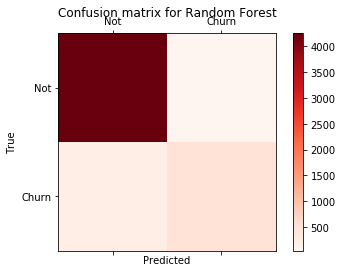

K-Nearest-Neighbors
Accuracy is 0.8858
Precision is 0.7361111111111112
Recall is 0.29985855728429983


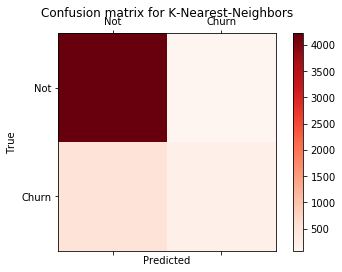

Logisitic Regression
Accuracy is 0.8644
Precision is 0.5674418604651162
Recall is 0.17256011315417255


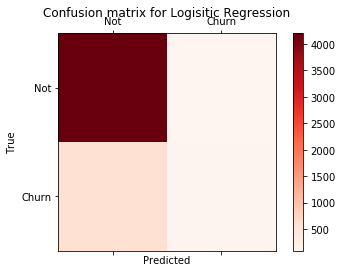

SVM
Accuracy is 0.8586
Precision is nan
Recall is 0.0


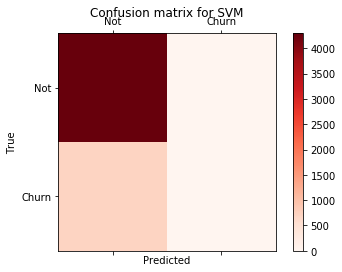

In [46]:
%matplotlib inline

y = np.array(y)
#class_names = np.unique(y)
#print (class_names)

"""

"""
confusion_matrices = [
    ("Random Forest", confusion_matrix(y,RF_CV_result)),
    ("K-Nearest-Neighbors", confusion_matrix(y,KNN_CV_result)),
    ("Logisitic Regression", confusion_matrix(y,LR_CV_result)),
    ("SVM", confusion_matrix(y, SVM_CV_result))
]

draw_confusion_matrices(confusion_matrices)

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

#### Part 4.1.1 - Compare Feature Coefficients

1. zip function: return a list of tuple
2. In order to get important parameter, we turn those coefficients into negative and sorted them. In this way, we can make the value with greater absoluted value display first.

In [35]:
LRmodel_l1 = LogisticRegression(penalty="l1")
LRmodel_l1.fit(X, y)
print ("Logistic Regression (L1) Coefficients")
for v,k in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (k + ": " + str(v))


Logistic Regression (L1) Coefficients
voice_mail_plan: -0.8659
number_customer_service_calls: 0.673
intl_plan: 0.613
total_day_minutes: 0.44
number_vmail_messages: 0.3961
total_day_charge: 0.2944
total_eve_charge: 0.2215
total_intl_calls: -0.1743
total_intl_minutes: 0.1467
total_eve_minutes: 0.1363
total_night_charge: 0.1147
total_intl_charge: 0.0967
total_night_minutes: 0.087
account_length: 0.0534
total_day_calls: 0.0495
total_night_calls: -0.0288
total_eve_calls: -0.0284


In [36]:
LRmodel_l2 = LogisticRegression(penalty="l2")
LRmodel_l2.fit(X, y)
LRmodel_l2.coef_[0]
print ("Logistic Regression (L2) Coefficients")
for v,k in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (k + ": " + str(v))

Logistic Regression (L2) Coefficients
voice_mail_plan: -0.8929
number_customer_service_calls: 0.6731
intl_plan: 0.6132
number_vmail_messages: 0.4234
total_day_minutes: 0.3687
total_day_charge: 0.3664
total_eve_charge: 0.18
total_eve_minutes: 0.1794
total_intl_calls: -0.1761
total_intl_charge: 0.1235
total_intl_minutes: 0.1217
total_night_minutes: 0.1028
total_night_charge: 0.1008
account_length: 0.0552
total_day_calls: 0.0513
total_night_calls: -0.0307
total_eve_calls: -0.0304


### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [37]:
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for v,k in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (k + ": " + str(v))

Feature importance ranking by Random Forest Model:
total_day_charge: 0.155
total_day_minutes: 0.1499
number_customer_service_calls: 0.1044
intl_plan: 0.0854
total_eve_minutes: 0.0674
total_eve_charge: 0.0602
total_intl_calls: 0.0518
total_intl_charge: 0.0434
total_night_charge: 0.0417
total_night_minutes: 0.0374
account_length: 0.0333
total_intl_minutes: 0.0328
total_night_calls: 0.0316
total_eve_calls: 0.0313
total_day_calls: 0.0313
number_vmail_messages: 0.0233
voice_mail_plan: 0.0196


# Part 5: Use Probabilities as Prediction Results

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

In [38]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

Result Evaluation: Use the ground truth probability to compare with our probability prediction results.

In [39]:
from collections import defaultdict
true_prob = defaultdict(float)

pred_prob = run_prob_cv(X, y, RandomForestClassifier, n_estimators=10)#n_estimators is for RandomeForest
pred_churn = pred_prob[:,1]
is_churn = (y == 1)
counts = pd.value_counts(pred_churn)
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])#The point is here
true_prob = pd.Series(true_prob)
true_prob

0.0    0.023088
0.1    0.034615
0.2    0.073529
0.3    0.122581
1.0    0.991870
0.9    0.982609
0.8    0.973684
0.7    0.901099
0.4    0.290698
0.6    0.755814
0.5    0.576923
dtype: float64

In [40]:
EvaResults = pd.concat([counts,true_prob], axis=1).reset_index()
EvaResults.columns = ['pred_prob', 'count', 'true_prob']
EvaResults

,pred_prob,count,true_prob
0,0.0,2772,0.023088
1,0.1,1040,0.034615
2,0.2,340,0.073529
3,0.3,155,0.122581
4,1.0,123,0.991870
5,0.9,115,0.982609
6,0.8,114,0.973684
7,0.7,91,0.901099
8,0.4,86,0.290698
9,0.6,86,0.755814
